In [48]:
import numpy as np
import gensim
import pandas as pd
import seaborn as sns
import ast
import re
import matplotlib.pyplot as plt
from neurotools.language.simple_tokenizer import SimpleTokenizer
%matplotlib inline

# Volkswagen Social Media Success #2

## Plan
1. Instead of averaging word vectors to represent a post, we stick with the individual tokens and define aggregate features defined on words with positive and negative similarities with each dimension
3. Get correlations between these defined features and the success metric.

## Notebook Contents
1. Load the tokenizer, embedding and data files
2. Define features based on token list
3. Correlations with dimensions
4. Conclusion

# Load the tokenizer, embedding and data files

In [49]:
emb = gensim.models.KeyedVectors.load_word2vec_format('data/pl_pl_commoncrawl_v3.bin', binary=True, encoding='utf-8', unicode_errors='ignore')

In [50]:
tokenizer = SimpleTokenizer('pl') 

Extra characters read for pl
Stopwords set read for pl
Lemma lookup read for pl


In [51]:
def get_average_vector(words, emb):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [52]:
dimensions = pd.read_csv('data/dimensions.csv')[['en_label', 'pl', 'en']]
dimensions = dimensions[~dimensions['pl'].isnull()].reset_index().drop(columns='index')
dimensions['pl'] = dimensions['pl'].map(tokenizer.tokenize)
dimensions['dimension'] = dimensions['pl'].map(lambda x: get_average_vector(x, emb))

/Users/piocalderon/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [53]:
simp = pd.read_csv('data/simplified_data.csv')
simp['Post_text'] = simp['Post_text'].map(ast.literal_eval)

# Define features based on token list

We define seven features for each dimension:
* **count_pos**: normalized count of words with positive similarity with dimension X
* **count_neg**: normalized count of words with negative similarity with dimension X
* **count_zero**: normalized count of words with zero similarity with dimension X
* **mean pos**: mean similarity of words with positive similarity with dimension X 
* **mean neg**: mean similarity of words with negative similarity with dimension X
* **peak pos**: max similarity of words with positive similarity with dimension X
* **peak neg**: min similarity of words with negative similarity with dimension X

![title](fig/feat_ext.png)

peak pos and peak neg are inspired by the 'peak' in the Peak-End rule, a psychological heuristic in which people judge an experience largely based on how they felt at its peak (i.e., its most intense point) https://en.wikipedia.org/wiki/Peak%E2%80%93end_rule

In [54]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [55]:
def get_similarity_with_dimension(x, emb, dim):
    counter = 0
    collect = []
    for word in x:
        try:
            collect.append(cosine_similarity(emb[word], dim))
            counter += 1
        except KeyError:
            continue
    return np.array(collect).mean()

In [56]:
def get_av_pos_neg_similarity_with_dimension(x, emb, dim):
    """
        Define features for token list x based on dimension dim
        
        Input:
            x : list of tokens
            emb : embedding model
            dim : average word vector of dimension
    """
    pos = []
    neg = []
    zero = []
    for word in x:
        try:
            sim = cosine_similarity(emb[word], dim)
            if sim > 0:
                pos.append(sim)
            elif sim < 0:
                neg.append(sim)
            else:
                zero.append(sim)
        except KeyError:
            continue
            
    total = 1.0 * len(pos + neg + zero)
    
    if len(pos) == 0:
        count_pos = np.nan
        mean_pos = np.nan
        peak_pos = np.nan
    else:
        count_pos = len(pos)/total
        mean_pos = np.array(pos).mean()
        peak_pos = max(pos)

    if len(neg) == 0:
        count_neg = np.nan
        mean_neg = np.nan
        peak_neg = np.nan
    else:
        count_neg = len(neg)/total
        mean_neg = np.array(neg).mean()
        peak_neg = min(neg)

    if len(zero) == 0:
        count_zero = np.nan
    else:
        count_zero = len(zero)/total
       
    return count_pos, mean_pos, peak_pos, count_neg, mean_neg, peak_neg, count_zero

In [57]:
labels = dimensions['en_label'].values

In [58]:
# define features across all posts for every dimension
for i in range(dimensions.shape[0]):
    simp['dim_{}_{}'.format(i, labels[i])] = simp['Post_text'].map(lambda x: get_av_pos_neg_similarity_with_dimension(x, emb, dimensions.iloc[i,3]))
    simp[['count_pos_{}_{}'.format(i, labels[i]), 
          'mean_pos_{}_{}'.format(i, labels[i]), 
          'peak_pos_{}_{}'.format(i, labels[i]), 
          'count_neg_{}_{}'.format(i, labels[i]), 
          'mean_neg_{}_{}'.format(i, labels[i]), 
          'peak_neg_{}_{}'.format(i, labels[i]),
          'count_zero_{}_{}'.format(i, labels[i])]] = pd.DataFrame(simp['dim_{}_{}'.format(i, labels[i])].values.tolist())

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [59]:
simp = simp[[x for x in simp.columns if not x.startswith('dim_')]]

In [60]:
simp.head()

,Post_text,success,count_pos_0_above,mean_pos_0_above,peak_pos_0_above,count_neg_0_above,mean_neg_0_above,peak_neg_0_above,count_zero_0_above,count_pos_1_african_names,...,mean_neg_124_pleasant_2,peak_neg_124_pleasant_2,count_zero_124_pleasant_2,count_pos_125_volkswagen,mean_pos_125_volkswagen,peak_pos_125_volkswagen,count_neg_125_volkswagen,mean_neg_125_volkswagen,peak_neg_125_volkswagen,count_zero_125_volkswagen
0,"[witać, wiek, rok, dzisiejszy, dzień, tylko, w...",3.625,0.846154,0.172996,0.303507,0.153846,-0.032549,-0.083773,NaN,0.230769,...,-0.044160,-0.078177,NaN,0.307692,0.068627,0.137124,0.692308,-0.092115,-0.174002,NaN
1,"[dakar, the, ultimate, rally, raca, oficjalnie...",4.500,0.500000,0.157677,0.320306,0.500000,-0.099303,-0.206650,NaN,0.666667,...,-0.095136,-0.232147,NaN,0.416667,0.134993,0.197607,0.583333,-0.065264,-0.129202,NaN
2,"[up, deklasować, konkurencja, zajrzeć, najnows...",15.125,0.851852,0.115193,0.350845,0.148148,-0.030552,-0.054795,NaN,0.296296,...,-0.079571,-0.185981,NaN,0.370370,0.091741,0.395422,0.629630,-0.073942,-0.135021,NaN
3,"[mały, ale, z, charakter, jaka, uważać, dodawa...",11.375,1.000000,0.178191,0.241080,NaN,NaN,NaN,NaN,0.375000,...,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.093608,-0.158542,NaN
4,"[taka, czas, wiek, rok, wiek, który, wyprzedaż...",15.500,0.648649,0.149445,0.269161,0.351351,-0.073554,-0.151106,NaN,0.405405,...,-0.047571,-0.118852,NaN,0.459459,0.218736,0.967951,0.540541,-0.070451,-0.180915,NaN


# Correlations with dimensions

In [61]:
# Look at corre
corr_matrix = simp.corr()
corr_success = corr_matrix['success']
corr_success = corr_success[~pd.isnull(corr_success)].sort_values(ascending=False)

In [62]:
upper = list(corr_success.iloc[1:26].index)
lower = list(corr_success.iloc[-25:].index)
dims_to_graph = upper + lower

In [63]:
to_bar = corr_success.loc[dims_to_graph].sort_values(ascending=True)
to_bar.index = [re.sub(r'_[0-9]+', '', x) for x in to_bar.index]

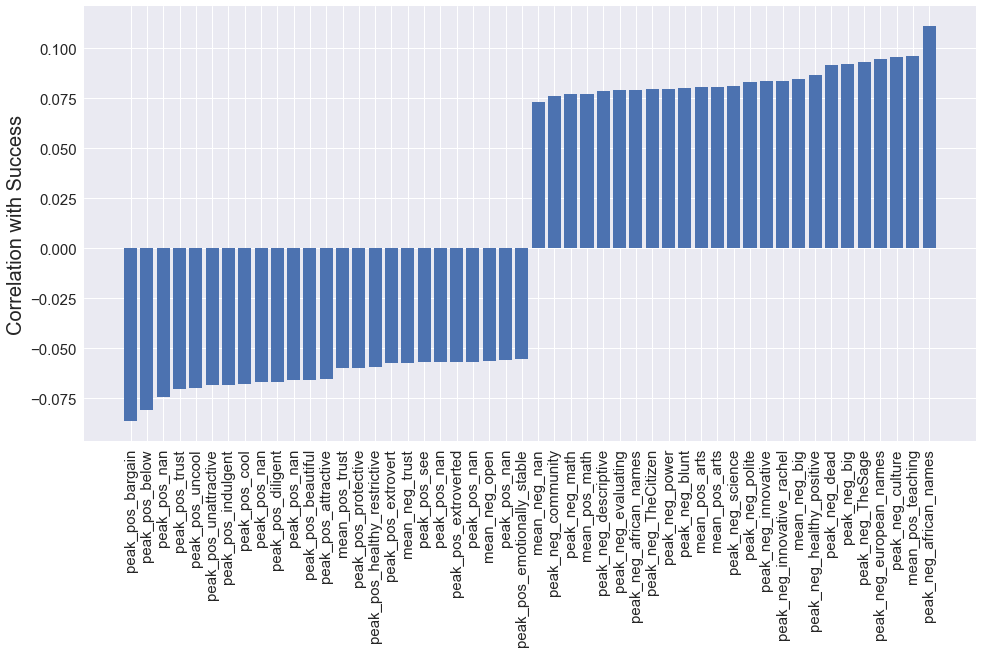

In [64]:
plt.figure(figsize=(16,8))
plt.bar(range(len(to_bar.index)), to_bar.values)
plt.xticks(range(len(to_bar.index)), to_bar.index, rotation=90, size=15);
plt.yticks(size=15);
plt.ylabel('Correlation with Success', size=20)
plt.savefig('./fig/bottom_top_dims_token_feats.png', bbox_inches='tight')

In [65]:
matrix_cols = ['success'] + dims_to_graph
correlogram = corr_matrix.loc[matrix_cols, matrix_cols]

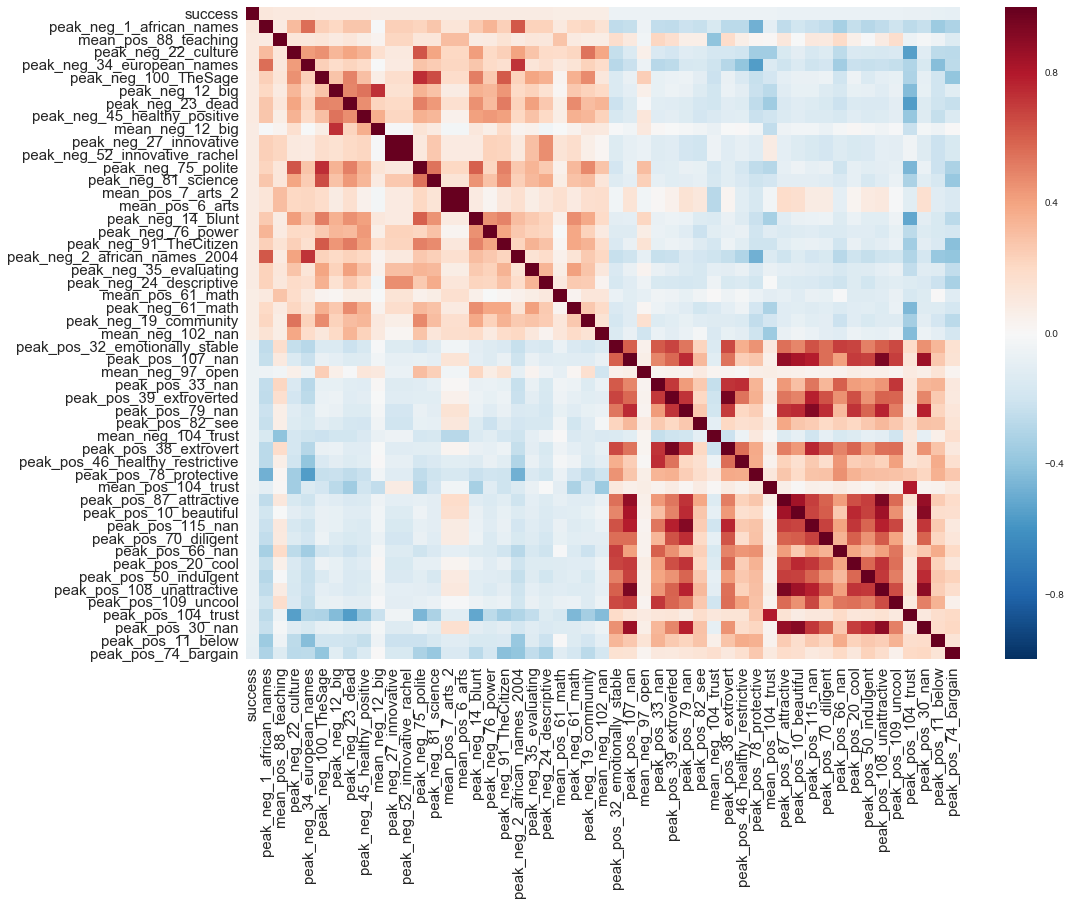

In [66]:
plt.figure(figsize=(16,12))
sns.heatmap(correlogram)
plt.xticks(size=15, rotation = 90);
plt.yticks(size=15, rotation = 0);
plt.savefig('./fig/corre_token_feats.png', bbox_inches='tight')

# Conclusion
Correlations here seem more intuitive than those obtained when just averaging word vectors. Particularly, we see that bargain and below are negatively correlated with success, while teaching, neg culture, neg dead, neg big are correlated with success. But there are still some big questions that remain, which I listed in To Do.

**To do**: 
* Look deeper into the correlation matrix and how it can be used for word choice.
* Figure out why innovative is negatively correlated with success here when it is positively correlated in the first presentation
* See why uncool and at the same time cool appear (as well as attractive and unattractive) appear on the same side. 
* Fix the labels in the images.

## For present:

In [75]:
top = ['mean_pos_88_teaching', 'peak_neg_23_dead', 'mean_pos_6_arts', 'peak_neg_14_blunt']
bot = ['peak_pos_74_bargain', 'peak_pos_50_indulgent']

In [76]:
top_bar = corr_success.loc[top].sort_values(ascending=True)
bot_bar = corr_success.loc[bot].sort_values(ascending=True)

In [77]:
top_bar

peak_neg_14_blunt       0.080033
mean_pos_6_arts         0.080667
peak_neg_23_dead        0.091479
mean_pos_88_teaching    0.096159
Name: success, dtype: float64

In [78]:
topl = ['less blunt\nassociations',  'more arts\nassociations', 'less dead\nassociations', 'more teaching\nassociations']
botl = ['more bargain\nassociations', 'more indulgent\nassociations']

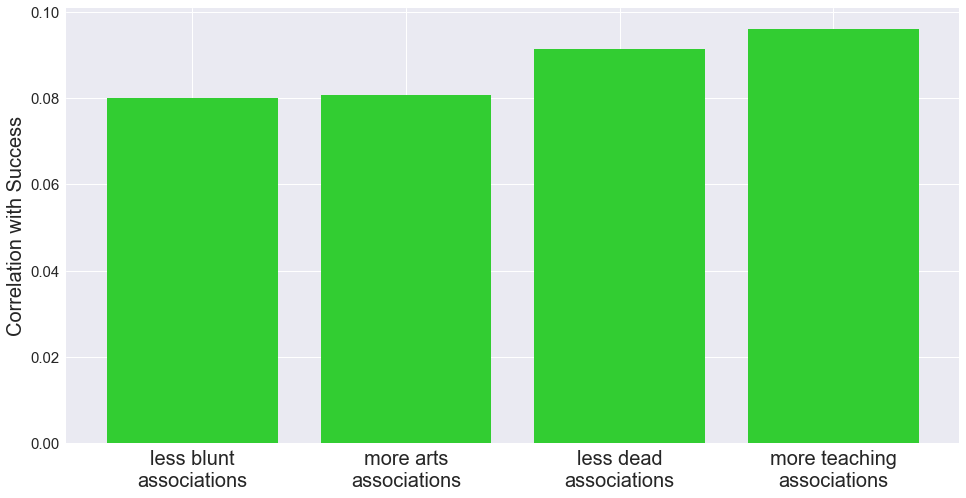

In [79]:
plt.figure(figsize=(16,8))
plt.bar(range(len(top_bar.index)), top_bar.values, color='limegreen')
plt.xticks(range(len(top_bar.index)), topl, rotation=0, size=20);
plt.yticks(size=15);
plt.ylabel('Correlation with Success', size=20)
plt.savefig('./fig/presentation_top.png', bbox_inches='tight');

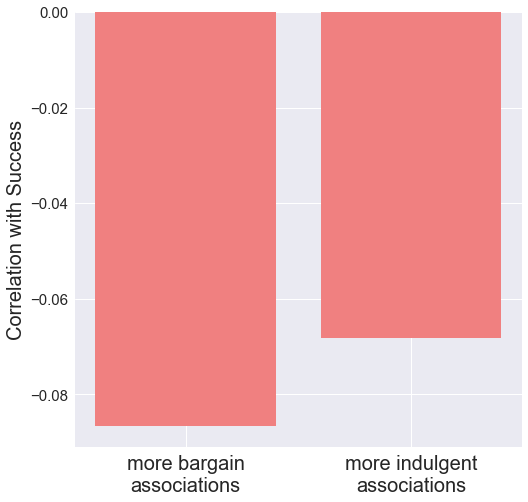

In [80]:
plt.figure(figsize=(8,8))
plt.bar(range(len(bot_bar.index)), bot_bar.values, color='lightcoral')
plt.xticks(range(len(bot_bar.index)), botl, rotation=0, size=20)
plt.yticks(size=15)
plt.ylabel('Correlation with Success', size=20)
plt.savefig('./fig/presentation_bot.png', bbox_inches='tight')

In [81]:
corr_labels = ['success'] + top + bot
simp_corr = corr_matrix.loc[corr_labels, corr_labels]

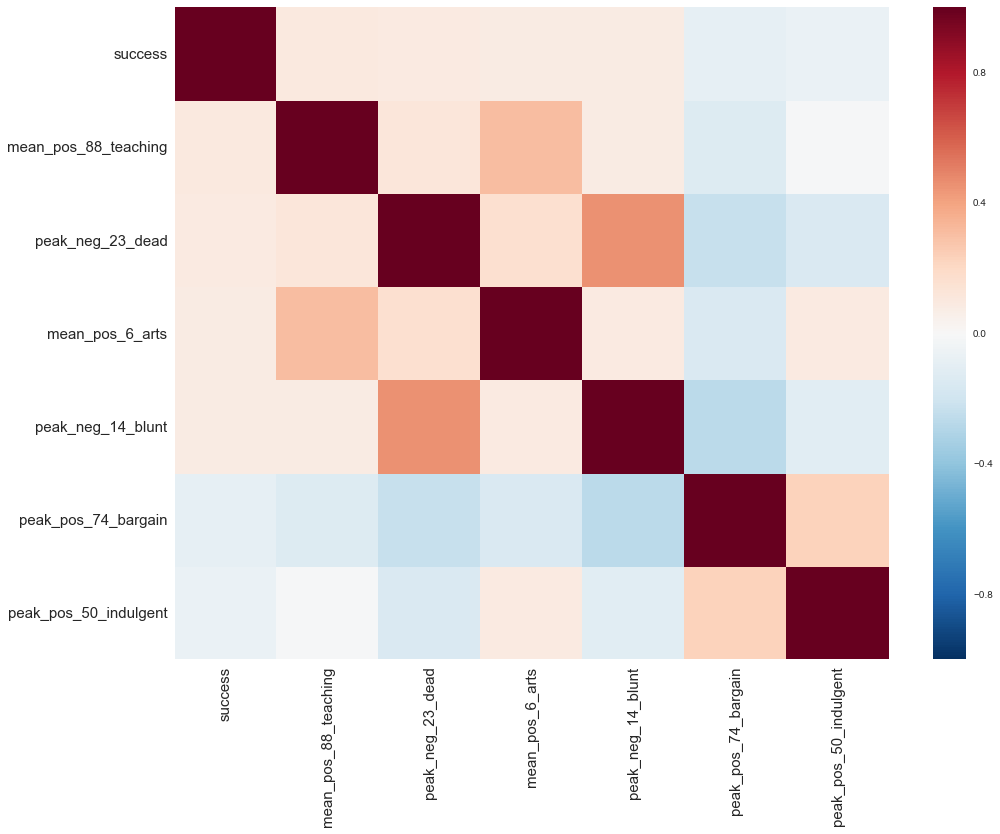

In [82]:
plt.figure(figsize=(16,12))
sns.heatmap(simp_corr)
plt.xticks(size=15, rotation = 90);
plt.yticks(size=15, rotation = 0);
plt.savefig('./fig/presentation_corr.png', bbox_inches='tight')